# The relative impacts of CO$_{2}$ and methane (CH$_{4}$)
### PCS Day 3, Jan. 2021

We now examine how the model introduced previously responds to a pulse injection of 100 Gigatonnes of carbon (GtC) in the form of CO2 in year 30.

# Model set up

Total delta T 10yr after emissions start = 0.31242
Total delta T 100yr after emissions start = 0.13776
Delta T from CO2 10yr after emissions start = 0.16540
Delta T from CO2 100yr after emissions start = 0.12923
Delta T from CH4 10yr after emissions start = 0.14587
Delta T from CH4 100yr after emissions start = 0.00770


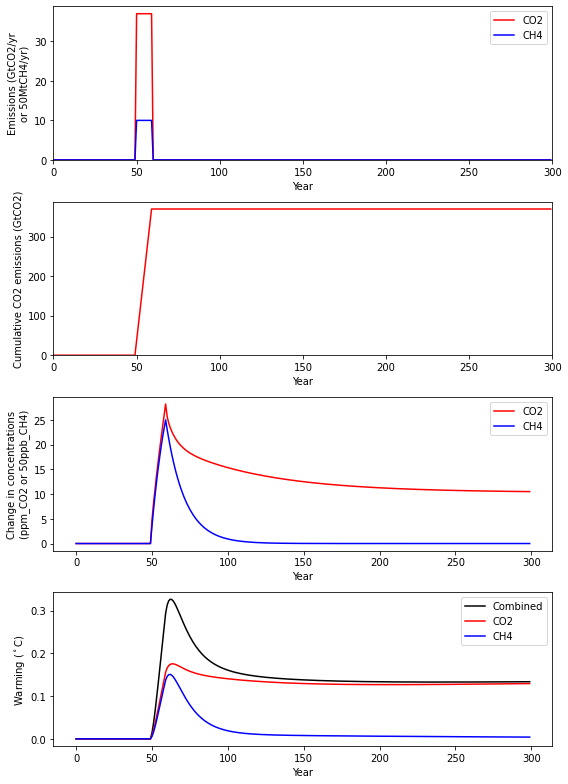

In [1]:
import numpy as np
import matplotlib.pyplot as plt # plotting routines
#The following line makes the plots appear in the web page, not in a separate window
%matplotlib inline
#Include all the routines we need to run the two-layer climate model
from fair_main_demo import *
#Create time and radiative forcing arrays

"""Set peak emissions rate of CO2 pulse, its duration and the year it starts. Note current emissions are ~37GtCO2/yr."""
peak_emissions_C=37 #units are GtCO2/yr
duration_C=10 #units are years
year_start_C=50

"""Set the same parameters for the methane emissions pulse. Note current emissions are ~500MtCH4/yr."""
peak_emissions_M=500 #units are MtCH4/yr
duration_M=10 #units are years
year_start_M=50

"""Set the same parameters for an N2O emissions pulse. Current emissions are ~9MtNO2/yr."""
peak_emissions_N=0. #units are MtN2O/yr
duration_N=0 #units are years
year_start_N=50

"""Set key model parameters"""
ECS=2.7 #equilibrium climate sensitivity (K), default=2.7K
TCR=1.6 #transient climate response (K), default=1.6K
#ECS = 6
#TCR = 0.4*ECS + 0.5
tau_s=4.1 #ocean mixed layer response time scale (years), default=4.1yrs
tau_d=239.0 #deep ocean response time scale (years), default=239.0yrs

#Create time axis
Y_frc=np.arange(300, dtype=float)

#Create CO2 emissions time series
peak_emissions_C=peak_emissions_C*12/44  #convert from emissions of CO2 to emissions of C
E_pls_C=np.zeros_like(Y_frc)
E_pls_C[year_start_C:year_start_C+duration_C]=peak_emissions_C

#Create CH4 emissions time series
E_pls_M=np.zeros_like(Y_frc)
E_pls_M[year_start_M:year_start_M+duration_M]=peak_emissions_M

#Create N2O emissions time series
E_pls_N=np.zeros_like(Y_frc)
E_pls_N[year_start_N:year_start_N+duration_N]=peak_emissions_N

#Calculate CH4 concentrations and radiative forcing (RF) arising from methane. 
#"emissions" has units MtCH4/yr and the RF has units W/m^2.
def rf_meth(emissions,lifetime=12.4,rad_eff=3.63e-4,conv=1./0.35):

  #Create array for concentration anomalies
  concs = np.zeros_like(emissions)
  #Integrate over time 
  for i in range(1,len(emissions)):
    concs[i] = concs[i-1] * np.exp(-1.0/lifetime) + emissions[i] / conv
  concs = concs 
  #Multiple by radiative efficiency of the increases atmospheric burden to get RF
  rf = rad_eff * concs

  return concs,rf

C_pls_M,rf_M=rf_meth(E_pls_M)

#Calculate N2O concentrations and RF in the same way
C_pls_N,rf_N=rf_meth(E_pls_N, lifetime=121, rad_eff=3.1e-3, conv=1/0.13)

#Run the model.
tcrecs=np.array([TCR,ECS])
d_vals=np.array([tau_s,tau_d])
C_0=278.  #initial CO2 concentration
other_rf=rf_M+rf_N  #forcing from CH4 and N2O
C_pls,T_pls=fair_scm(E_pls_C,tcrecs=tcrecs,d=d_vals,other_rf=other_rf,C_0=C_0)

#Calculate warming due to CO2, CH4 separately, if methane emissions are greater than zero. Include the impact of N2O 
#separately if include_N2O=True
if (not np.all(E_pls_M==0.)) or (not np.all(E_pls_N==0.)):
    C_pls_CO2,T_pls_CO2=fair_scm(E_pls_C,tcrecs=tcrecs,d=d_vals,C_0=C_0)
    if (not np.all(E_pls_M==0.)):
        C_pls_CH4,T_pls_CH4=fair_scm(np.zeros_like(E_pls_C),tcrecs=tcrecs,d=d_vals,other_rf=rf_M,C_0=C_0)
    if (not np.all(E_pls_N==0.)):
        C_pls_N2O,T_pls_N2O=fair_scm(np.zeros_like(E_pls_N),tcrecs=tcrecs,d=d_vals,other_rf=rf_N,C_0=C_0)

#Now plot results
fig=plt.figure(figsize = (8,11))

plt.subplot(411)
plt.axis([0., 300., min(0,np.min([E_pls_C.min()*44/12,E_pls_M.min()/50.,E_pls_N.min()/10.])), 
          np.max([E_pls_C.max()*44/12,E_pls_M.max()/50.,E_pls_N.max()/10.])*1.05])
ylabel="Emissions ("
plt.plot(Y_frc,E_pls_C*44/12,color='red',label="CO2")
ylabel+="GtCO2/yr"
if (not np.all(E_pls_M==0.)):
    plt.plot(Y_frc,E_pls_M/50.,color='blue',label="CH4")
    ylabel+="\nor 50MtCH4/yr"
    plt.legend()
if (not np.all(E_pls_N==0.)):
    plt.plot(Y_frc,E_pls_N/10.,color='green',label="N2O")
    ylabel+=" or 10MtN2O/yr"
    plt.legend()
#else:
    #plt.ylabel("Emissions (GtCO2/yr)")
ylabel+=")"
plt.ylabel(ylabel)
plt.xlabel("Year")


plt.subplot(412)
cumu_emissions=np.cumsum(E_pls_C)
plt.axis([0., 300., min(0,cumu_emissions.min()*44/12*1.05), cumu_emissions.max()*44/12*1.05])
plt.plot(Y_frc,cumu_emissions*44/12,color='red')
plt.ylabel("Cumulative CO2 emissions (GtCO2)")
plt.xlabel("Year")

plt.subplot(413)
plt.plot(Y_frc,C_pls-C_0,color='red',label="CO2")
ylabel="Change in concentrations\n(ppm_CO2"
if (not np.all(E_pls_M==0.)):
    plt.plot(Y_frc,C_pls_M/50.,color='blue',label="CH4")
    ylabel+=" or 50ppb_CH4"
    plt.legend()
if (not np.all(E_pls_N==0.)):
    plt.plot(Y_frc,C_pls_N/50.,color='green',label="N2O")
    ylabel+=" or 50ppb_N2O"
    plt.legend()
#else:
    #plt.ylabel("Change in concentration (ppm)")
ylabel+=")"
plt.ylabel(ylabel)
plt.xlabel("Year")

plt.subplot(414)
if (not np.all(E_pls_M==0.)) or (not np.all(E_pls_N==0.)):
    plt.plot(Y_frc,T_pls,color='black',label='Combined')
    plt.plot(Y_frc,T_pls_CO2,color='red',label='CO2')
    if (not np.all(E_pls_M==0.)):
        plt.plot(Y_frc,T_pls_CH4,color='blue',label='CH4')
    if (not np.all(E_pls_N==0.)):
        plt.plot(Y_frc,T_pls_N2O,color='green',label='N2O')
    plt.legend()
else:
    plt.plot(Y_frc,T_pls,color='red') 
plt.ylabel("Warming ($^\circ$C)")
plt.xlabel("Year")

#Calculate warming 10yr and 100yr after emissions begin across all gases. 
#Start by finding the earliest year at which emissions begin.
if (not np.all(E_pls_M==0.)) and (not np.all(E_pls_N==0.)):
    em_start_yr=min(year_start_C,year_start_M,year_start_N)
elif (not np.all(E_pls_M==0.)):
    em_start_yr=min(year_start_C,year_start_M)
elif (not np.all(E_pls_N==0.)):
    em_start_yr=min(year_start_C,year_start_N)
else:
    em_start_yr=year_start_C
    
print("Total delta T 10yr after emissions start = {:.5f}".format(T_pls[em_start_yr+10]))
print("Total delta T 100yr after emissions start = {:.5f}".format(T_pls[em_start_yr+100]))
if (not np.all(E_pls_M==0.)) or (not np.all(E_pls_N==0.)):
    print("Delta T from CO2 10yr after emissions start = {:.5f}".format(T_pls_CO2[em_start_yr+10]))
    print("Delta T from CO2 100yr after emissions start = {:.5f}".format(T_pls_CO2[em_start_yr+100]))
if (not np.all(E_pls_M==0.)):
    print("Delta T from CH4 10yr after emissions start = {:.5f}".format(T_pls_CH4[em_start_yr+10]))
    print("Delta T from CH4 100yr after emissions start = {:.5f}".format(T_pls_CH4[em_start_yr+100]))
if (not np.all(E_pls_N==0.)):
    print("Delta T from N2O 10yr after emissions start = {:.5f}".format(T_pls_N2O[em_start_yr+10]))
    print("Delta T from N2O 100yr after emissions start = {:.5f}".format(T_pls_N2O[em_start_yr+100]))
    
plt.tight_layout()

# A few things to try

 - Vary the strength and duration of the radiative forcing perturbation, what do you notice about the response of the radiative forcing and temperature changes? How is this different from the GHG response?

 - Is the ratio of temperature change to radiative forcing constant? Why is this?

## What happens if you change the parameters?

 - What effect on the temperature response is made by varying the equilibrium climate sensitivity (ECS), transient climate response (TCR), the ocean mixed layer response time scale and the deep ocean response time scale? 
 
  - These are labelled `ECS`, `TCR`, `tau_s` and `tau_d` in the model code! Look near the top :) 
  
  
 - In the GHG-dominated case, all of these parameters mattered, what about now?


# Does this make you more of less confident in the prospects for geoengineering?